
# Hands-On 1: Predictive vs Prescriptive Modeling
*A business-focused, code-first walkthrough*

## 🎯 Learning Goals
- Know the difference between **predictive** and **prescriptive** modeling
- Train a simple **predictive** model (regression) to estimate demand/sales
- Build a **prescriptive** optimization to choose the best actions under constraints
- Connect ML predictions to optimization decisions



## 1️⃣ Concepts at a Glance
- **Predictive modeling**: learns a function \(\hat{y}=f(\mathbf{x})\) from historical data to forecast outcomes (e.g., *sales next week*).
- **Prescriptive modeling**: chooses **actions** \(\mathbf{a}\) that **optimize** an objective (e.g., *maximize profit*) subject to constraints.

> In practice, you often **predict first**, then **prescribe** using those predictions.



## 2️⃣ Dataset (Synthetic Business Scenario)
We'll simulate weekly **sales** from:
- `price` (higher price generally lowers sales)
- `ad_spend_tv` and `ad_spend_online` (marketing drives sales)
- binary `is_holiday` (holiday boosts sales)

Then we train a regression model to **predict sales** from controllable features.


In [1]:

import numpy as np
import pandas as pd
rng = np.random.default_rng(7)

n = 300
df = pd.DataFrame({
    "price": rng.normal(20, 3, n).clip(5),
    "ad_spend_tv": rng.normal(8, 2.5, n).clip(0),
    "ad_spend_online": rng.normal(5, 1.8, n).clip(0),
    "is_holiday": rng.choice([0, 1], n, p=[0.85, 0.15]),
})

# True sales function + noise
true_sales = (
    4
    - 0.9 * df["price"]
    + 2.1 * df["ad_spend_tv"]
    + 2.8 * df["ad_spend_online"]
    + 3.5 * df["is_holiday"]
    + rng.normal(0, 2.0, n)
)

df["sales"] = np.round(true_sales, 2)
df.head()


,price,ad_spend_tv,ad_spend_online,is_holiday,sales
0,20.003690,11.779574,2.048973,1,21.82
1,20.896237,9.389220,6.045209,0,24.18
2,19.177586,7.853850,4.900747,1,22.73
3,17.328224,6.551520,5.555137,0,20.50
4,18.635988,6.412504,1.944168,0,5.85



## 3️⃣ Predictive Modeling (Regression)
We'll split the data into train/test, fit **Linear Regression**, and evaluate with MAE and R².


In [2]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

features = ["price", "ad_spend_tv", "ad_spend_online", "is_holiday"]
X = df[features]
y = df["sales"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg = LinearRegression().fit(X_train, y_train)
pred_test = reg.predict(X_test)

mae = mean_absolute_error(y_test, pred_test)
r2 = r2_score(y_test, pred_test)
mae, r2, dict(zip(features, reg.coef_)), reg.intercept_


(1.7210035549082496,
 0.9346296163739878,
 {'price': np.float64(-0.7759004739581435),
  'ad_spend_tv': np.float64(2.226021173902205),
  'ad_spend_online': np.float64(2.8310353459579667),
  'is_holiday': np.float64(3.4000460063078974)},
 np.float64(0.4969923083439376))


### Visualize Predictions vs Actuals


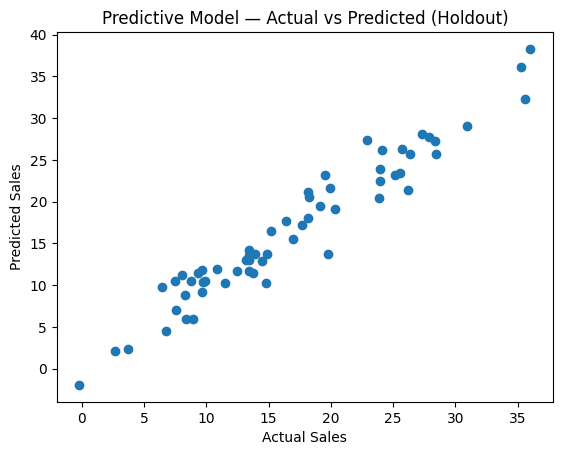

In [3]:

import matplotlib.pyplot as plt
plt.figure()
plt.scatter(y_test, pred_test)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Predictive Model — Actual vs Predicted (Holdout)")
plt.show()



## 4️⃣ Prescriptive Modeling (Optimization)
**Business question**: Given a **weekly marketing budget**, how should we split it between **TV** and **Online** to **maximize profit**?

We will:
1. Use the regression model as a **surrogate** to predict sales for a given `price`, `ad_spend_tv`, `ad_spend_online`, and `is_holiday`.
2. Define **profit** = `revenue - cost` with:
   - `revenue = sales × unit_price`
   - marketing cost: `c_tv × ad_spend_tv + c_online × ad_spend_online`
3. Optimize allocation under constraints:
   - Budget: `c_tv * tv + c_online * online ≤ B`
   - Bounds: `tv ≥ 0`, `online ≥ 0`
   - Optional: cap spends or enforce minimums


In [4]:

from scipy.optimize import minimize

# Scenario settings (decision context)
unit_price = 22.0         # selling price per unit
c_tv = 1.0                # cost per "unit" TV spend
c_online = 1.0            # cost per "unit" online spend
budget = 18.0             # total spend budget
is_holiday = 0            # 1 if holiday week, else 0
price = 20.0              # chosen price for the week

def predict_sales(price, tv, online, is_holiday):
    import numpy as np
    x = np.array([[price, tv, online, is_holiday]])
    return float(reg.predict(x)[0])

def neg_profit(vars_):
    tv, online = vars_
    # predict sales at this decision point
    s = predict_sales(price, tv, online, is_holiday)
    revenue = unit_price * s
    cost = c_tv * tv + c_online * online
    profit = revenue - cost
    return -profit  # we minimize negative profit

# Constraints and bounds
cons = ({
    "type": "ineq",
    "fun": lambda v: budget - (c_tv * v[0] + c_online * v[1])  # <= budget
},)
bounds = [(0, None), (0, None)]

# Initial guess
x0 = [budget/2, budget/2]

res = minimize(neg_profit, x0=x0, bounds=bounds, constraints=cons, method="SLSQP", options={"maxiter": 500})
res.success, res.message, res.x, -res.fun


/Users/subhasht/Desktop/VSCode Programs/GenAI_Curriculum/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/subhasht/Desktop/VSCode Programs/GenAI_Curriculum/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/subhasht/Desktop/VSCode Programs/GenAI_Curriculum/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/subhasht/Desktop/VSCode Programs/GenAI_Curriculum/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/subhasht/Desktop/VSCo

(True,
 'Optimization terminated successfully',
 array([ 0., 18.]),
 np.float64(772.6276192374937))


### Interpret the Solution
The optimizer proposes a split (`tv`, `online`) within the budget that **maximizes estimated profit** according to the predictive model.


In [5]:

opt_tv, opt_online = res.x
opt_sales = predict_sales(price, opt_tv, opt_online, is_holiday)
opt_revenue = unit_price * opt_sales
opt_cost = c_tv * opt_tv + c_online * opt_online
opt_profit = opt_revenue - opt_cost

pd.DataFrame({
    "decision": ["TV spend", "Online spend", "Predicted sales", "Revenue", "Cost", "Profit"],
    "value": [round(opt_tv,2), round(opt_online,2), round(opt_sales,2), round(opt_revenue,2), round(opt_cost,2), round(opt_profit,2)]
})


/Users/subhasht/Desktop/VSCode Programs/GenAI_Curriculum/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


,decision,value
0,TV spend,0.00
1,Online spend,18.00
2,Predicted sales,35.94
3,Revenue,790.63
4,Cost,18.00
5,Profit,772.63



## 5️⃣ Sensitivity: Budget vs Profit
Let's visualize how **profit** changes as we vary the **budget** while re-optimizing spend allocation each time.


/Users/subhasht/Desktop/VSCode Programs/GenAI_Curriculum/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/subhasht/Desktop/VSCode Programs/GenAI_Curriculum/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/subhasht/Desktop/VSCode Programs/GenAI_Curriculum/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/subhasht/Desktop/VSCode Programs/GenAI_Curriculum/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/subhasht/Desktop/VSCo

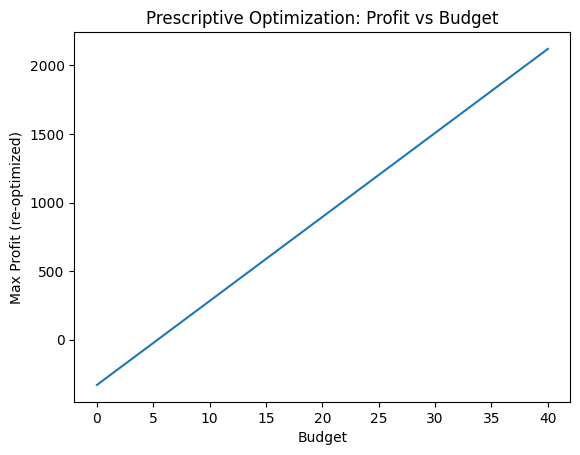

In [6]:

budgets = np.linspace(0, 40, 21)
profits = []

for B in budgets:
    def neg_profit_b(v):
        tv, online = v
        # budget constraint penalty (soft) to help solver stay feasible
        penalty = 0.0
        if (c_tv * tv + c_online * online) > B:
            penalty = 1e3 * ((c_tv * tv + c_online * online) - B)
        s = predict_sales(price, tv, online, is_holiday)
        revenue = unit_price * s
        cost = c_tv * tv + c_online * online
        return -(revenue - cost) + penalty

    r = minimize(neg_profit_b, x0=[B/2, B/2], bounds=[(0, None), (0, None)], method="SLSQP", options={"maxiter": 300})
    profits.append(-r.fun)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(budgets, profits)
plt.xlabel("Budget")
plt.ylabel("Max Profit (re-optimized)")
plt.title("Prescriptive Optimization: Profit vs Budget")
plt.show()



## 6️⃣ Summary
- **Predictive** models estimate outcomes from inputs (we used linear regression to forecast sales).
- **Prescriptive** models choose actions by maximizing an objective under constraints (we used `scipy.optimize.minimize`).  
- The two are complementary: predictions feed optimization, which in turn influences data collected for future learning (feedback loop).
